# Genetic Algorithms 1: A simple genetic algorithm

In this example we will look at a basic genetic algorithm (GA). We will set up the GA to try to match a pre-defined 'optimal. solution. Often with GAs we are using them to find solutions to problems which 1) cannot be solved with 'exact' methods (methods are are guaranteed to find the best solution), and 2) where we cannot recognise when we have found the optimal solution. GAs therefore fall into a collection of algorithms called heuristic (from Greek for 'search') algorithms that hunt down good solutions, without us knowing how far off the theoretical optimal solution they are.

In this case however we will test the algorithms against a solution we know we are looking for.

## Principles of genetic algorithms (GAs)

GAs are iterating algorithms, that is they repeatedly loop through a progress until a target is reached or a maximum number of iterations (called 'generations' in GAs) is reached.

The basic steps of a genetic algorithm are:

1) Create a population of randomly generated solutions, coded as binary arrays, and score population for performance (or 'fitness') of each individual.

2) Loop (until target performance is reached or a maximum number of generations is reached):
	
a) Select two parents to 'breed'. Selection is based on performance (or 'fitness') - better performing parents are more likely to be selected.
  
b) Generate two child solutions from two parents by mixing the genes from each parent and by applying a chance of random mutation.
  
c) Repeat child generation until a required new population size is reached.
  
d) Score new population

## The solution to 'hunt down'

We code most GAs to work with binary strings (or a binary NumPy array, as we will use here), so that the solution may be represented as a series of 0 and 1.

A real-life example in healthcare is that the array of 0s and 1s may represents the choices of closed or open hospital units providing a given service. We then evaluate each solution against predetermined criteria.

Here we will define a known solution based on a string of 70 0s or 1s. The number of possible combinations for this is 2^18, or 1.2 x 10^18 - that is 1 followed by eighteen zeros. Or, to put it another way (as these large numbers are difficult to imagine) ......  the universe is about 15 billion (15 x 10^9) years old, or 5 x 10^17 seconds old. If we could evaluate 1,000 solutions per second, then a computer would need to run for twice the current age of the universe in order to evaluate all possible combinations. Let's see how close to the perfect solution we can get in reasonable time! 

In GA we will call each potential solution to be evaluated a 'chromsome'. Each element (a 0 or 1) in that chromsome is a 'gene'.

In [1]:
import random
import numpy as np

def create_reference_solution(chromosome_length):

    number_of_ones = int(chromosome_length / 2)

    # Build an array with an equal mix of zero and ones
    reference = np.zeros(chromosome_length)
    reference[0: number_of_ones] = 1

    # Shuffle the array to mix the zeros and ones
    np.random.shuffle(reference)
    
    return reference

Let's test the function and show an example 70-gene reference chromosome.

In [2]:
# Print an example target array
print (create_reference_solution(70))

[1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0.]


## Create a starting random population 

We will use NumPy to store our population. Each row will represent one solution, which will contain a random sequence of zeros and ones. The number of rows will represent to number of 'individuals, in our population.

In [3]:
def create_starting_population(individuals, chromosome_length):
    # Set up an initial array of all zeros
    population = np.zeros((individuals, chromosome_length))
    # Loop through each row (individual)
    for i in range(individuals):
        # Choose a random number of ones to create
        ones = random.randint(0, chromosome_length)
        # Change the required number of zeros to ones
        population[i, 0:ones] = 1
        # Sfuffle row
        np.random.shuffle(population[i])
    
    return population
    

Let's test by showing a random population of 4 individuals with a gene length of 10.

In [4]:
print (create_starting_population(4, 10))

[[1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0. 1. 0.]]


## Calculate fitness of population

In GAs we refer to how good each individual in the population is, as 'fitness'. The calculate_fitness function will be the evaulation procedure you wish to apply in your alogrith. In this example we are going to retrurn the number of genes (elements) in a potential solution (chromose) that match our f=reference standard.

In [5]:
def calculate_fitness(reference, population):
    # Create an array of True/False compared to reference
    identical_to_reference = population == reference
    # Sum number of genes that are identical to the reference
    fitness_scores = identical_to_reference.sum(axis=1)
    
    return fitness_scores

Let's test what we have so far:

In [6]:
reference = create_reference_solution(10)
print ('Reference solution: \n', reference)
population = create_starting_population(6, 10)
print ('\nStarting population: \n', population)
scores = calculate_fitness(reference, population)
print('\nScores: \n', scores)

Reference solution: 
 [1. 1. 0. 0. 0. 1. 1. 0. 1. 0.]

Starting population: 
 [[1. 0. 1. 1. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Scores: 
 [2 6 6 6 4 6]


## Choosing individuals to breed with tournament selection

Genetic algorithms mimic biology in that the individuals with the best fitness cores are most likely to breed and pass on their genes. But we do not simply take all the best individuals from our population to breed, as this might risk 'in-breeding'. Rather, we use a method that means better individuals are moire likely to breed, but low fitness individuals at times may be choosen to breed.

In tournament selection we first choose two individuals at random from our population (it is possible that two low fitness individuals may be chosen). We then pass those individuals to a 'tournament' where the individual with the highest fitness will be chosen.

It is possible to further modify this so that the highest fitness individual will win with a given probability, but we will keep it simple here and have the highest fitness individual always winning.
It is also possible to have more than two individuals in a tournament. The more individuals in a tournament the more the picked population will be biased towards the highest fitness individuals.

In [7]:
def select_individual_by_tournament(population, scores):
    # Get population size
    population_size = len(scores)
    
    # Pick individuals for tournament
    fighter_1 = random.randint(0, population_size-1)
    fighter_2 = random.randint(0, population_size-1)
    
    # Get fitness score for each
    fighter_1_fitness = scores[fighter_1]
    fighter_2_fitness = scores[fighter_2]
    
    # Identify undividual with highest fitness
    # Fighter 1 will win if score are equal
    if fighter_1_fitness >= fighter_2_fitness:
        winner = fighter_1
    else:
        winner = fighter_2
    
    # Return the chromsome of the winner
    return population[winner, :]

Let's test selection of parents:

In [8]:
# Set up and score population
reference = create_reference_solution(10)
population = create_starting_population(6, 10)
scores = calculate_fitness(reference, population)

# Pick two parents and dispplay
parent_1 = select_individual_by_tournament(population, scores)
parent_2 = select_individual_by_tournament(population, scores)
print (parent_1)
print (parent_2)

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]


## Producing children from parents - crossover

When two individuals are chosen, the next step is to produce 'children' from them. We produce these children by 'crossover' mix of their two chromosomes. We choose a random point within the chromosome, and then one 'child' will take the left portion (up to, but not including, the crossover point) from parent 1 and the corresponding right portion from parent 2. The result is a mix of genes from each parent. The second 'child' will be the opposite of this -  portion (up to, but not including) the crossover point) from parent 2 and the corresponding right portion from parent 1.

It is possible to have more than one crossover point, but we will keep it simple and have a single crossover point.

In [9]:
def breed_by_crossover(parent_1, parent_2):
    # Get length of chromosome
    chromosome_length = len(parent_1)
    
    # Pick crossover point, avoding ends of chromsome
    crossover_point = random.randint(1,chromosome_length-1)
    
    # Create children. np.hstack joins two arrays
    child_1 = np.hstack((parent_1[0:crossover_point],
                        parent_2[crossover_point:]))
    
    child_2 = np.hstack((parent_2[0:crossover_point],
                        parent_1[crossover_point:]))
    
    # Return children
    return child_1, child_2

And let's test it so far, creating a population, scoring it, picking two 'parents' and producing 'two children'.

In [10]:
# Set up and score population
reference = create_reference_solution(15)
population = create_starting_population(100, 15)
scores = calculate_fitness(reference, population)

# Pick two parents and dispplay
parent_1 = select_individual_by_tournament(population, scores)
parent_2 = select_individual_by_tournament(population, scores)

# Get children
child_1, child_2 = breed_by_crossover(parent_1, parent_2)

# Show output
print ('Parents')
print (parent_1)
print (parent_2)
print ('Children')
print (child_1)
print (child_2)

Parents
[1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]
Children
[1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0.]
[0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.]


## Random mutation of genes

In evolotion sometimes genes are copied incorrectly. This change may be harmful or beneficial. We mimic this by having a certain probability of that a gene (which is either a 0 or a 1) becomes switched.

Typically this probability is low (e.g. 0.005), though it can be made to be flexible (e.g. increase mutation rate if progress has stalled)

In [11]:
def randomly_mutate_population(population, mutation_probability):
    
    # Apply random mutation
        random_mutation_array = np.random.random(
            size=(population.shape))
        
        random_mutation_boolean = \
            random_mutation_array <= mutation_probability

        population[random_mutation_boolean] = \
        np.logical_not(population[random_mutation_boolean])
        
        # Return mutation population
        return population

Let's test our function with a high mutation rate (0.25) to see the effects. You can change the mutation rate and see what happens (a mutation rate of 1.0 will invert all genes).

In [12]:
# Set up and score population
reference = create_reference_solution(15)
population = create_starting_population(100, 15)
scores = calculate_fitness(reference, population)

# Pick two parents and display
parent_1 = select_individual_by_tournament(population, scores)
parent_2 = select_individual_by_tournament(population, scores)

# Get children and make new population 
child_1, child_2 = breed_by_crossover(parent_1, parent_2)
population = np.stack((child_1, child_2))

# Mutate population
mutation_probability = 0.25
print ("Population before mutation")
print (population)
population = randomly_mutate_population(population, mutation_probability)
print ("Population afer mutation")
print (population)

Population before mutation
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Population afer mutation
[[1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]]


## Putting it all together

We've defined all the functions we need. Now let's put it all together.

Starting best score, percent target: 65.3
End best score, percent target: 100.0


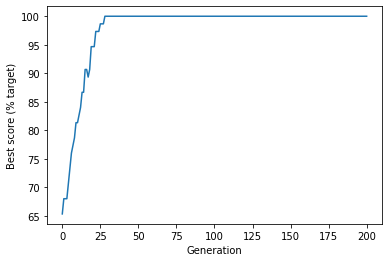

In [13]:
# Set general parameters
chromosome_length = 75
population_size = 500
maximum_generation = 200
best_score_progress = [] # Tracks progress

# Create reference solution 
# (this is used just to illustrate GAs)
reference = create_reference_solution(chromosome_length)

# Create starting population
population = create_starting_population(population_size, chromosome_length)

# Display best score in starting population
scores = calculate_fitness(reference, population)
best_score = np.max(scores)/chromosome_length * 100
print ('Starting best score, percent target: %.1f' %best_score)

# Add starting best score to progress tracker
best_score_progress.append(best_score)

# Now we'll go through the generations of genetic algorithm
for generation in range(maximum_generation):
    # Create an empty list for new population
    new_population = []
    
    # Create new popualtion generating two children at a time
    for i in range(int(population_size/2)):
        parent_1 = select_individual_by_tournament(population, scores)
        parent_2 = select_individual_by_tournament(population, scores)
        child_1, child_2 = breed_by_crossover(parent_1, parent_2)
        new_population.append(child_1)
        new_population.append(child_2)
    
    # Replace the old population with the new one
    population = np.array(new_population)
    
    # Apply mutation
    mutation_rate = 0.002
    population = randomly_mutate_population(population, mutation_rate)
        
    # Score best solution, and add to tracker
    scores = calculate_fitness(reference, population)
    best_score = np.max(scores)/chromosome_length * 100
    best_score_progress.append(best_score)

# GA has completed required generation
print ('End best score, percent target: %.1f' %best_score)

# Plot progress
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(best_score_progress)
plt.xlabel('Generation')
plt.ylabel('Best score (% target)')
plt.show()